# VotingClassifier
Link: 

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import class_weight

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


## 1. Target
Income Levels
 + 1 : extreme poverty
 + 2 : moderate poverty
 + 3 : vulnerable households
 + 4 : non vulnerable households

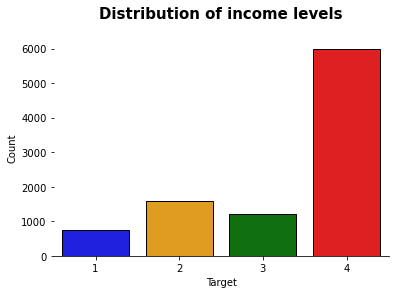

In [3]:
target = train['Target'].value_counts().reset_index().sort_values(by = 'index')
ax = sns.barplot(data = target, x = 'index', y = 'Target', edgecolor = 'k', palette = ['blue', 'orange', 'green', 'red'])
plt.xlabel('Target'); plt.ylabel('Count'); plt.title('Distribution of income levels', fontsize = 15, fontweight = 'bold', pad = 20)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

## 2. Missing values

In [4]:
train.isnull().sum().sort_values(ascending = False)/len(train)

rez_esc        0.829549
v18q1          0.768233
v2a1           0.717798
meaneduc       0.000523
SQBmeaned      0.000523
                 ...   
hogar_total    0.000000
dependency     0.000000
edjefe         0.000000
edjefa         0.000000
Id             0.000000
Length: 143, dtype: float64

Missing values를 확인해본 결과, NaN이 의미하는 것은 예를 들어 tablet이 없다(개수 = 0), monthly rent payment가 없다(=0)을 의미한다. 따라서 missing value를 0으로 대체한다.

In [5]:
print('Years behind in school: \n', train['rez_esc'].unique())
print('Number of tablets household owns: \n', train['v18q1'].unique())
print('Monthly rent payment: \n', train['v2a1'].unique())

Years behind in school: 
 [nan  1.  0.  3.  2.  4.  5.]
Number of tablets household owns: 
 [nan  1.  2.  3.  4.  5.  6.]
Monthly rent payment: 
 [ 190000.  135000.      nan  180000.  130000.  100000.   90000.  215000.
  150000.  120000.   80000.  168000.   40000.  155000.  200000.  350000.
  270000.  300000.  250000.  260000.  564834.  175000.   25310.  400000.
  450000.  399378.  119813.  125518.  125000.   60000.   35000.  160000.
  170000.  500000.  230000.  185000.  220000.  570540.  342324.       0.
  127000.   52000.  240000.  278000.   70000.  110000.  100297.  210000.
  770229.  285270.  145000.   96000.  542013.   65000.   85000.  104000.
  275000.  140000.  280000.  105661.   20000.   16000.   55000.   30000.
  283000.  245000.  191500.  510000.   36350.   89000.  600000.   75000.
   50000.   84529.  550000.  132000.  470000.   27000.  176000.  205000.
  380000.  855810.  427905.  290975.  188000.  118097.  360000.  325000.
 1000000.  700000.  288750.  219087.   95000.   930

In [6]:
# 나머지 결측값은 평균값으로 대체
train = train.fillna(0)

## 3. Feature Engineering

In [7]:
def encode_data(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])
    
def do_features(df):
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2'),
                ]
    
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]

    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)       
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
    
    # aggregation rules over household
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']
               }
    
    aggs_cat = {'dis': ['mean']}
    for s_ in ['estadocivil', 'parentesco', 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean', 'count']

    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    df.drop(['Id'], axis=1, inplace=True)
    
    return df

In [8]:
def process_df(df_):
    encode_data(df_)
    return do_features(df_)

train = process_df(train)
test = process_df(test)

In [9]:
train['escolari'].unique()

array([10, 12, 11,  9,  2,  0,  3,  4, 15, 16,  6, 13,  8,  1, 17,  7, 14,
        5, 21, 19, 18, 20], dtype=int64)

In [10]:
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

train.loc[train['edjefa'] == 'no', 'edjefa'] = 0
train.loc[train['edjefe'] == 'no', 'edjefe'] = 0
test.loc[test['edjefa'] == 'no', 'edjefa'] = 0
test.loc[test['edjefe'] == 'no', 'edjefe'] = 0

train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

# convert to int for our models
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")
test['edjefe'] = test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

# create feature with max education of either head of household
train['edjef'] = np.max(train[['edjefa','edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']], axis=1)

train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

In [11]:
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_:
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_:
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele']
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df

In [12]:
def train_test_apply_func(train_, test_, func_):
    test_['Target'] = 0
    xx = pd.concat([train_, test_])

    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :].drop('Target', axis=1)

    del xx, xx_func
    return train_, test_

train, test = train_test_apply_func(train, test, convert_OHE2LE)

The OHE in techo is incomplete. A new column will be added before label encoding
The OHE in instlevel is incomplete. A new column will be added before label encoding
The OHE in manual_elec is incomplete. A new column will be added before label encoding


In [13]:
cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE', 
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

def convert_geo2aggs(df_):
    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
                        pd.get_dummies(df_[cols_2_ohe], 
                                       columns=cols_2_ohe)],axis=1)

    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])
    
    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
train, test = train_test_apply_func(train, test, convert_geo2aggs)

In [14]:
train['num_over_18'] = 0
train['num_over_18'] = train[train.age >= 18].groupby('idhogar').transform("count")
train['num_over_18'] = train.groupby("idhogar")["num_over_18"].transform("max")
train['num_over_18'] = train['num_over_18'].fillna(0)

test['num_over_18'] = 0
test['num_over_18'] = test[test.age >= 18].groupby('idhogar').transform("count")
test['num_over_18'] = test.groupby("idhogar")["num_over_18"].transform("max")
test['num_over_18'] = test['num_over_18'].fillna(0)

# add some extra features, these were taken from another kernel
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1
    
extract_features(train)    
extract_features(test)   

In [15]:
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

needless_cols.extend(instlevel_cols)

train = train.drop(needless_cols, axis = 1)
test = test.drop(needless_cols, axis = 1)

## 4. XGBoost

In [24]:
X = train.query('parentesco1 == 1')
y = X['Target']-1
X = X.drop(['Target'], axis = 1)

# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

train_household = X_train['idhogar']

(2378, 175)
(595, 175)
(2378,)
(595,)


In [25]:
extra_drop_features = [
 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil7_COUNT',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco6_COUNT',
 'agg18_parentesco7_COUNT',
 'agg18_parentesco8_COUNT',
 'agg18_parentesco9_COUNT',
 'geo_elimbasu_LE_4',
 'geo_energcocinar_LE_1',
 'geo_energcocinar_LE_2',
 'geo_epared_LE_0',
 'geo_hogar_mayor',
 'geo_manual_elec_LE_2',
 'geo_pared_LE_3',
 'geo_pared_LE_4',
 'geo_pared_LE_5',
 'geo_pared_LE_6',
 'num_over_18',
 'parentesco_LE',
 'rez_esc']

xgb_drop_cols = extra_drop_features + ["idhogar",  'parentesco1']

In [26]:
# evaluation metric: Macro f1 score
def evaluate_macroF1_lgb(predictions, truth):  
    pred_labels = predictions.argmax(axis = 1)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', 1-f1) 

In [54]:
fit_params = {'early_stopping_rounds': 500,
              'evel_metric': evaluate_macroF1_lgb,
              'eval_set': [(X_train, y_train), (X_val, y_val)],
              'verbose': 100}

opt_params = opt_parameters = {'max_depth':35, 'objective':'multi:softmax', 'min_child_weight': 1, 'num_class': 4, 'gamma': 2.0, 'colsample_bylevel': 0.9, 'subsample': 0.84, 'colsample_bytree': 0.88, 'reg_lambda': 0.40,
                              'eval_metric': 'mlogloss'}

#### VotingClassifier 사용법
 + estimators = [(model name1, model1), (model name2, model2)]
```python
voting_model = VotingClassifier(estimators=[ ('LogisticRegression', logistic_regression),
                                            ('KNN', knn) ], voting='soft')
```

#### class_weight 
 + class_weight: 'balanced', None
  - balanced: n_samples / (n_classes * np.bincount(y))
  - None: uniform weights

In [ ]:
clfs = []

for i in range(15):
    clf = xgb.XGBClassifier(random_state = 10+i, n_estimators = 1500, learning_rate = 0.15, **opt_params)
    
    clfs.append(('xgb{}'.format(i), clf))

vc = VotingClassifier(clfs, voting = 'soft')
del(clfs)

y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices = None)

_ = vc.fit(X_train.drop(xgb_drop_cols, axis = 1), y_train, sample_weight = y_train_weights)

In [69]:
y_pred = vc.predict(X_val.drop(xgb_drop_cols, axis = 1))
f1_score(y_val, y_pred, average = 'macro')

0.3936462019139292

In [58]:
clf_final = vc.estimators_[0]

In [63]:
def feature_importance(forest, X_train, display_results=True):
    ranked_list = []
    zero_features = []
    
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]
    
    if display_results:
        # Print the feature ranking
        print("Feature ranking:")

    for f in range(X_train.shape[1]):
        if display_results:
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " + X_train.columns[indices[f]])
        
        ranked_list.append(X_train.columns[indices[f]])
        
        if importances[indices[f]] == 0.0:
            zero_features.append(X_train.columns[indices[f]])
            
    return ranked_list, zero_features

In [65]:
useless_feat = []
drop_feat = set()
counter = 0

for est in vc.estimators_:
    ranked_features, unused_features = feature_importance(est, X_train.drop(xgb_drop_cols, axis=1), display_results=False)
    useless_feat.append(unused_features)
    if counter == 0:
        drop_features = set(unused_features)
    else:
        drop_features = drop_features.intersection(set(unused_features))
    counter += 1
    
drop_features

{'agg18_estadocivil5_COUNT', 'geo_energcocinar_LE_0', 'geo_manual_elec_LE_3'}